In [1]:
%reset -f 
# from __future__ import absolute_import, print_function
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import signal
from matplotlib import rcParams
from scipy import io
import os
import imageio


In [2]:
# Widening the screen
from IPython.core.display import display
from IPython.display import HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

rcParams['figure.dpi'] = 600
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral' # 'StixGeneral','Helvetica', 'sans-serif'; 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana'
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

### Simulation settings

In [3]:
length    = 512.0      # 2.5 Length of the physical landscape
n         = 512        # Size of the 2D grid
endtime   = 10000.0       #end time
dT        = 0.02        #0.02     #calculate time step
nplot     = 100
nsteps    = np.ceil(endtime/nplot/dT).astype(int)    #number of time steps

### Precalculations

In [4]:
dX = length/n      # Spatial step size
dY = length/n      # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 512 x 512 cells



### Defining the device that is used

In [5]:
# Setting up the OpenCL context
DeviceNr = 0   # 0 = GTX 960M
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

 Compute Device: Tesla P40



### Parameter definition 

In [6]:
# parameters
Ds     =     1.0              # 1    - The diffusivity parameter on S
Dh     =     5.05             # 0.01 - The diffusivity parameter on H
kappa  =     0.15
v0     =     2.02
win    =     0.5              # control height of needle ice
a      =     0.2              # reduce coefficient of stone on needle ice height
alpha  =     0.5              # 1/d/tau
beta   =     0.2              # beta vaule b*v0

S0_max =     0.40
S0_min =     0.40
Lambda_max=  3.8             # p1 max mean=2.47
Lambda_min=  3.8             # p1 min
p0 = 2.09
p1 = 3.0
p2 = 1.73

### Initial values

In [7]:
# The array is allocated on the GPU and the initial values are copied onto it
T        = np.tile(np.logspace(np.log10(S0_min),np.log10(S0_max),n),n)#np.tile(np.linspace(3.0,11.0,n),n)
# S
S        = (np.random.rand(n*n)-0.5)*0.2 + T #2.0
S_host   = S.astype(np.float32)
S_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=S_host)
# H
H        = (np.random.rand(n*n)-0.5 )*0.1  + 1.0
H_host   = H.astype(np.float32)
H_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=H_host)
# CoeffS
CoeffS        = S*0.0
CoeffS_host   = CoeffS.astype(np.float32)
CoeffS_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=CoeffS_host)
# CoeffH
CoeffH        = S*0.0
CoeffH_host   = CoeffH.astype(np.float32)
CoeffH_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=CoeffH_host)
# TS
TS       = S*0.0
TS_host  = TS.astype(np.float32)
TS_g     = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=TS_host)
#parameter ->array
#Da array -> GPU
lambda_arr        = np.linspace(Lambda_max,Lambda_min,n).repeat(n) #np.logspace(np.log10(3.3),np.log10(0.3),n).repeat(n)#np.logspace(np.log10(3.3),np.log10(0.3),n).repeat(n)#0.85
lambda_arr_host   = lambda_arr.astype(np.float32)
lambda_arr_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=lambda_arr_host)

### Defining the OpenCL simulation kernel

In [8]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel
PassVars="Ds,Dh,kappa,v0,win,a,alpha,beta,p0,p1,p2,dX,dY,dT,Grid_Width,Grid_Height"

PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

In [9]:
ComputeCode = """

////////////////////////////////////////////////////////////////////////////////
// Laplacation operator definition, to calculate diffusive fluxes
////////////////////////////////////////////////////////////////////////////////

static float d2_dxy2(__global float* pop)
{
    // Getting thread coordinates on the grid
    size_t current = get_global_id(0);
    size_t row     = (size_t)(current/Grid_Width);
    size_t column  = current%Grid_Width;
    
    // Computing positions of the neighbors
    size_t left    = row * Grid_Width + column-1;
    size_t right   = row * Grid_Width + column+1;
    size_t top     = (row-1) * Grid_Width + column;
    size_t bottom  = (row+1) * Grid_Width + column;
    
    float retval = ( (pop[left] - 2.0*pop[current] + pop[right]) )
                     /(float)dX/(float)dX +
                   ( (pop[top]  - 2.0*pop[current] + pop[bottom]))
                     /(float)dY/(float)dY;
    
    return retval;
}

///////////////////////////////////////////////////////////////////////////////
// Divergence of Gradient operator definition 
///////////////////////////////////////////////////////////////////////////////
#define min(a,b) (((a)<(b))?(a):(b))
#define max(a,b) (((a)>(b))?(a):(b))
static float DivGrad(__global float* pop, __global float* qoq)
{
    // Getting thread coordinates on the grid
    size_t current = get_global_id(0);
    size_t row     = (size_t)(current/Grid_Width);
    size_t column  = current%Grid_Width;
    
    // Computing positions of the neighbors
    size_t left    = row * Grid_Width + column-1;
    size_t right   = row * Grid_Width + column+1;
    size_t top     = (row-1) * Grid_Width + column;
    size_t bottom  = (row+1) * Grid_Width + column;
    
    float retval = ((pop[left]+pop[current])*(qoq[left]-qoq[current])/2.0 - (pop[current]+ pop[right])*(qoq[current]-qoq[right] )/2.0 )/(float)dX/(float)dX +
                   ((pop[top] +pop[current])*(qoq[top] -qoq[current])/2.0 - (pop[current]+pop[bottom])*(qoq[current]-qoq[bottom])/2.0 )/(float)dY/(float)dY;

    return retval;
}

////////////////////////////////////////////////////////////////////////////////
// Simulation kernel
////////////////////////////////////////////////////////////////////////////////

__kernel void Simulation_Kernel(__global float* S, __global float* H, __global float* CoeffS, __global float* CoeffH, __global float* TS, __global float* lambda_arr)
{
    size_t current = get_global_id(0);
    int row        = floor((float)current/(float)Grid_Width);
    int column     = current%Grid_Width;
    
    if(row > 1 && row < Grid_Height-2 && column > 1 && column < Grid_Width-2)
    {
        float d = Ds;
        CoeffS[current] = alpha*(p2*S[current]*S[current]-lambda_arr[current]*S[current]+p0) * (3.0*p2*S[current]*S[current]-2.0*lambda_arr[current]*S[current]+p0);
        CoeffH[current] = 0.0;
        TS[current] = kappa*d2_dxy2(S);
        S[current]  = max(0.0f,S[current]+dT*( DivGrad(CoeffS, S)  - d*d2_dxy2(TS) ));
        H[current]  = 0.0; // max(0.0f,H[current]+dT*( win - a*S[current]*S[current]*H[current] + Dh*d2_dxy2(H) ));
    }
    // HANDLE Boundaries
   else if(row<=1) // Lower boundary
    {
        S[current]=     S[(row + Grid_Height-4)*Grid_Width + column];
        H[current]=     H[(row + Grid_Height-4)*Grid_Width + column];
        CoeffS[current]=CoeffS[(row + Grid_Height-4)*Grid_Width + column];
        CoeffH[current]=CoeffH[(row + Grid_Height-4)*Grid_Width + column];
        TS[current]=    TS[(row + Grid_Height-4)*Grid_Width + column];
    }
    else if(row>=Grid_Height-2) // Upper boundary
    {
        S[current]=S[(row-Grid_Height+4) * Grid_Width + column];
        H[current]=H[(row-Grid_Height+4) * Grid_Width + column];
        CoeffS[current]=CoeffS[(row-Grid_Height+4) * Grid_Width + column];
        CoeffH[current]=CoeffH[(row-Grid_Height+4) * Grid_Width + column];
        TS[current]=TS[(row-Grid_Height+4) * Grid_Width + column];
    }
    else if(column<=1) // Left boundary
    {
        S[current]=     S[row * Grid_Width +column+Grid_Width - 4];
        H[current]=     H[row * Grid_Width +column+Grid_Width - 4];
        CoeffS[current]=CoeffS[row * Grid_Width +column+Grid_Width - 4];
        CoeffH[current]=CoeffH[row * Grid_Width +column+Grid_Width - 4];
        TS[current]=    TS[row * Grid_Width +column+Grid_Width - 4];
    }
    else if(column>=Grid_Width-2) // Right boundary
    {
        S[current]=     S[row * Grid_Width + column - Grid_Width+4];
        H[current]=     H[row * Grid_Width + column - Grid_Width+4];
        CoeffS[current]=CoeffS[row * Grid_Width + column - Grid_Width+4];
        CoeffH[current]=CoeffH[row * Grid_Width + column - Grid_Width+4];
        TS[current]=    TS[row * Grid_Width + column - Grid_Width+4];
    }
   // barrier(CLK_GLOBAL_MEM_FENCE);   
}  // End Simulation_Kernel
"""

### Here the kernel is compiled

In [10]:
program = cl.Program(context, Params + ComputeCode).build()

In [11]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 

As=np.zeros((Grid_Width, Grid_Height, nplot))
Bs=np.zeros((Grid_Width, Grid_Height, nplot))

# Set up simulation parameters
global_size = S_host.shape

# Start the timer:
start_time = time.time()

# Starting the loop
for ii in range(1,nplot):
    # The simulation
    # We store the state of the system for <NumPlot> different times.
    As[:,:,ii] = S_host.reshape(Grid_Width, Grid_Height)
#     Bs[:,:,ii] = H_host.reshape(Grid_Width, Grid_Height) 
    for jj in range(1,nsteps):      
        program.Simulation_Kernel(queue, global_size, None, S_g, H_g, CoeffS_g, CoeffH_g, TS_g, lambda_arr_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, S_host, S_g)
#     cl.enqueue_copy(queue, H_host, H_g)

    PB.value += 1 # signal to increment the progress bar
#     print(PB)
# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

Progress :


FloatProgress(value=0.0)

 Simulation took      : 42.9 (s)


# Plotting the results

Lossy conversion from float64 to uint8. Range [0.22546221315860748, 1.4459195137023926]. Convert image to uint8 prior to saving to suppress this warning.


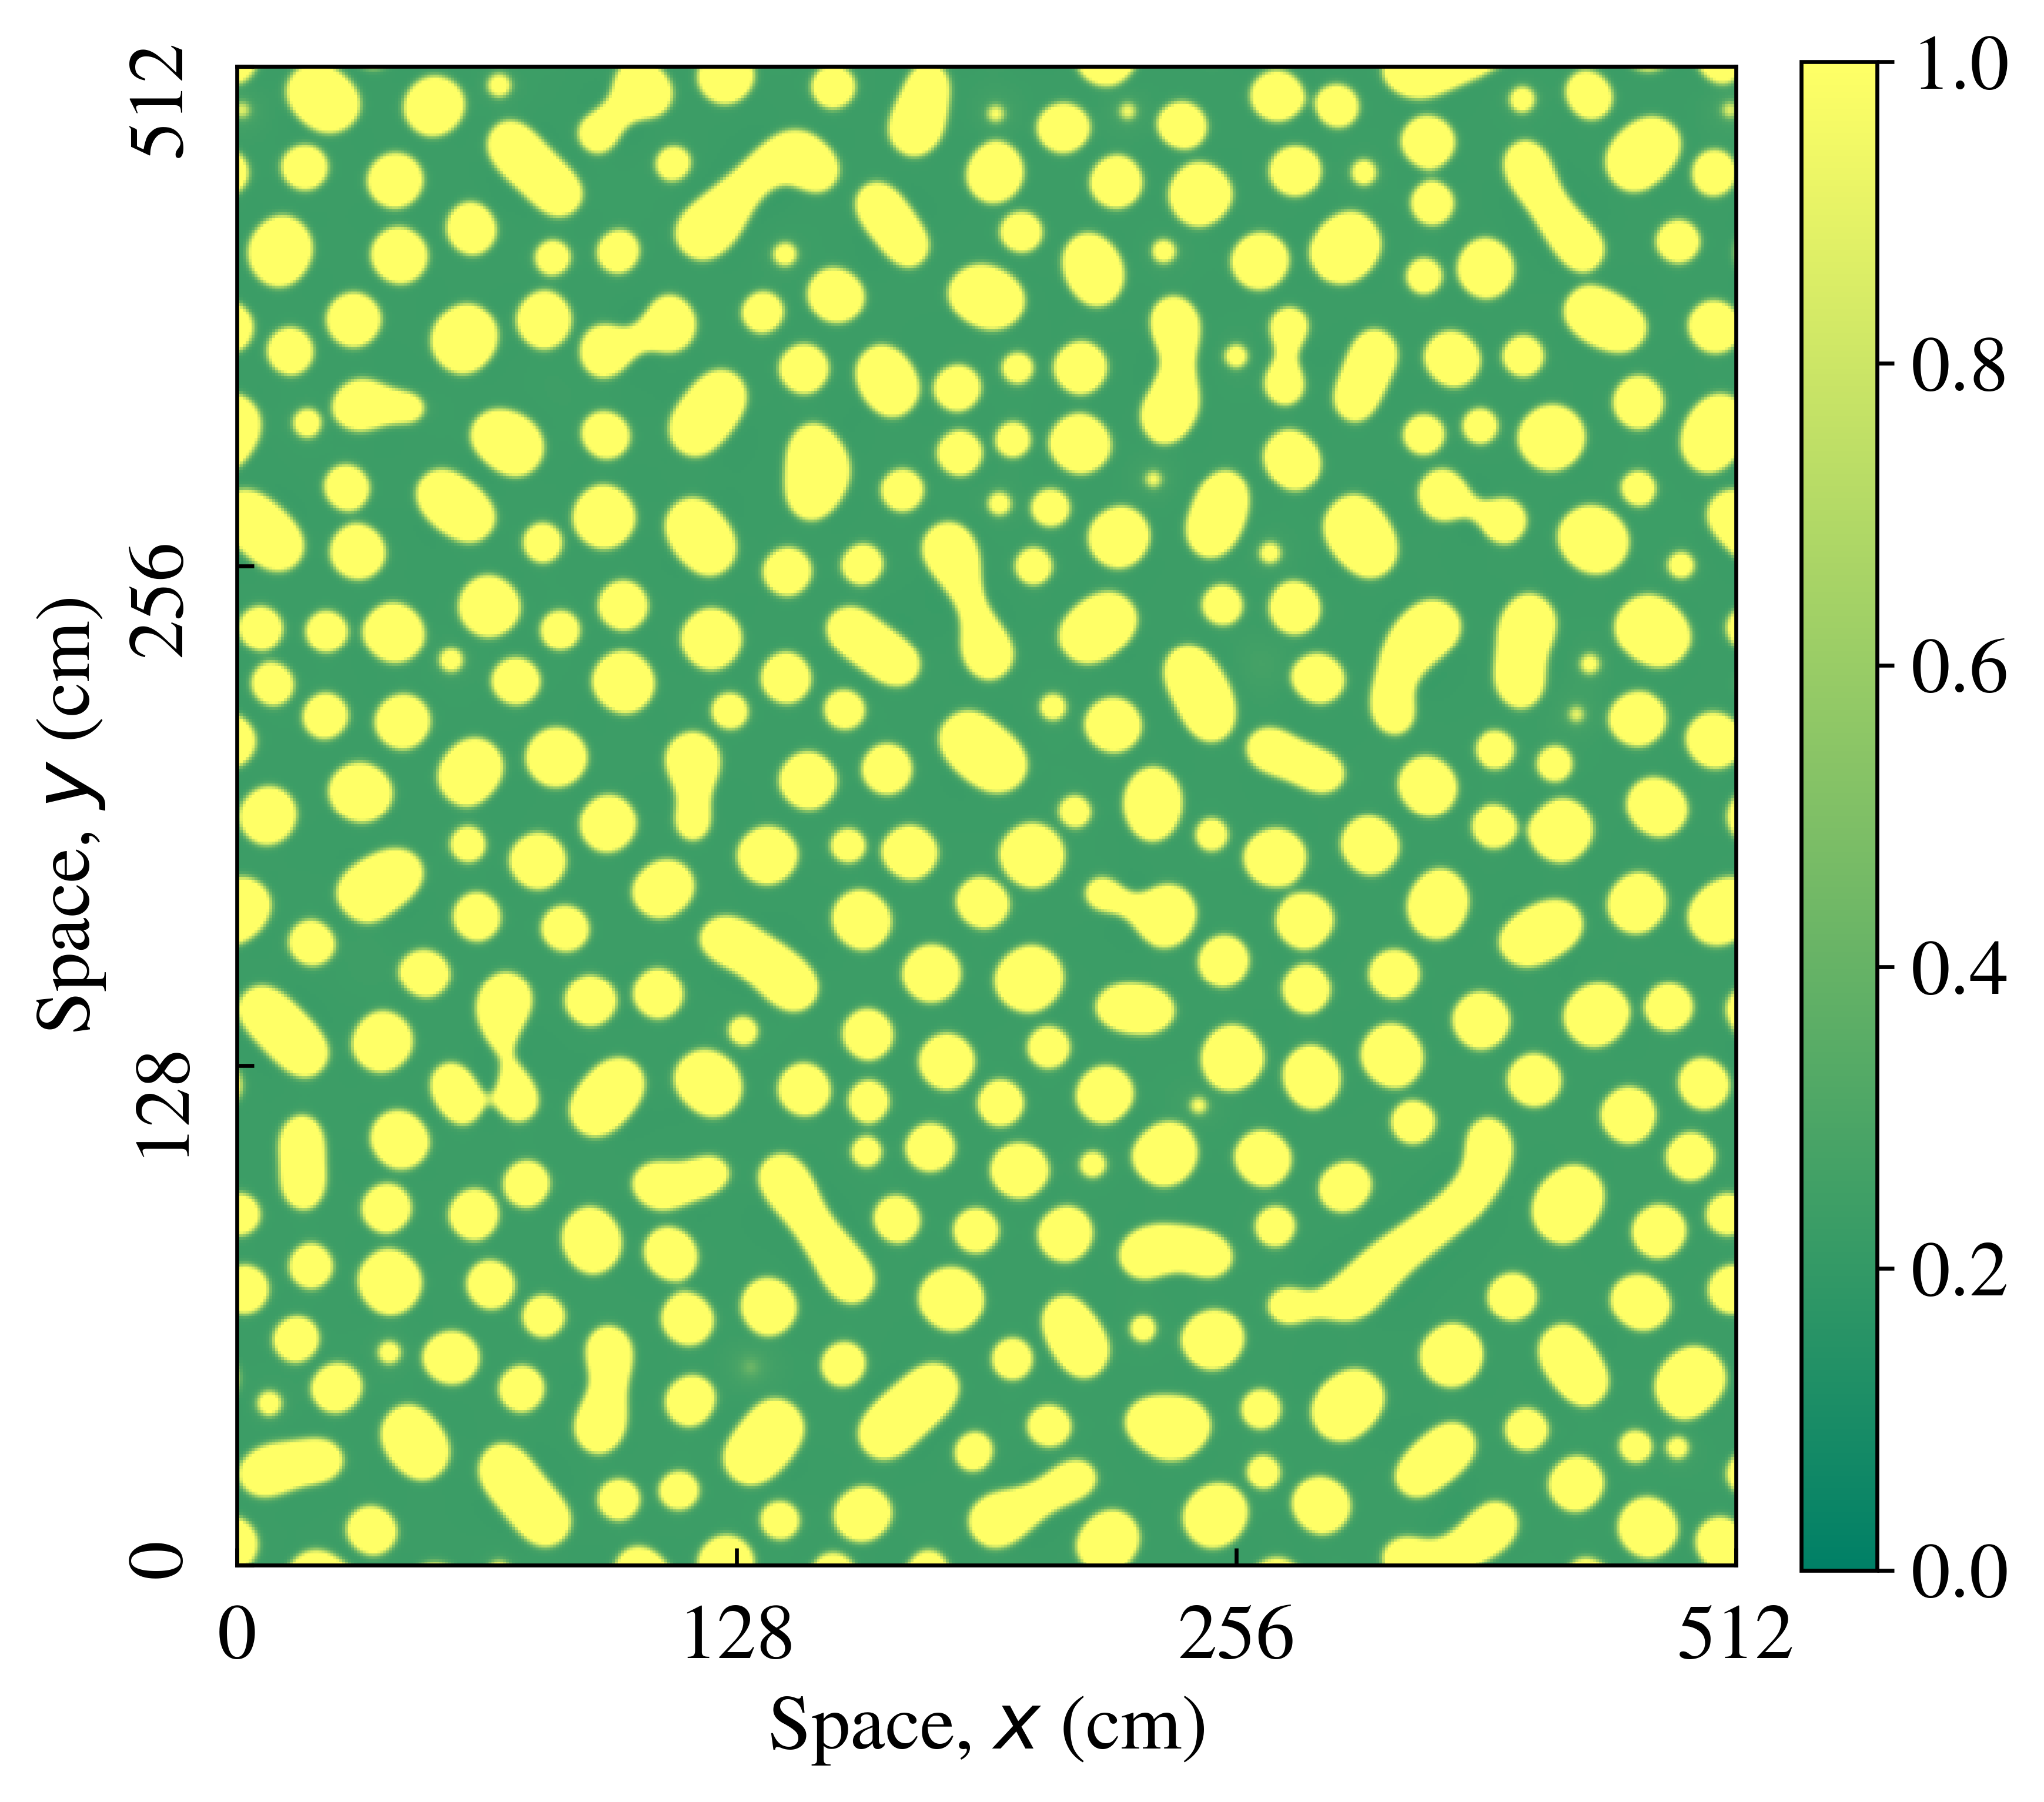

In [12]:
### The Simulation loop
nticker = 4
orig_map=plt.cm.get_cmap('YlGn') # viridis,  YlGn
reversed_map = orig_map.reversed()

from matplotlib import ticker
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im0 = ax.imshow(As[:,:,-1],cmap='summer',extent=[0,length,0,length],clim=(0,1.0));#, clim=(0,0.1));

ax.set_xlabel('Space, $x$ (cm)');
ax.set_ylabel('Space, $y$ (cm)');
cbar=plt.colorbar(im0, ax=ax,fraction=0.046,pad=0.04);

tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
# Xlabels = np.linspace(0,length,nticker).round(0)
# Ylabels = np.linspace(0,length,nticker).round(0)
ax.set_xticks(np.linspace(0,length,nticker))
# ax.set_xticklabels(Xlabels)
ax.set_xticklabels([0, 128, 256,512])

ax.set_yticks(np.linspace(0,length,nticker))
# ax.set_yticklabels(Ylabels)
ax.set_yticklabels([0, 128, 256, 512], rotation=90)
ax.tick_params(axis="both", direction="in", pad=8)

fig.savefig('Pattern_Quadratic_Speed'+ str(S0_min)+'.pdf',bbox_inches='tight')
imageio.imwrite('Pattern_Quadratic_Speed_OneKernel'+ str(S0_min)+'.png',As[:,:,99])


In [13]:
# print(As[:,:,-1])

In [14]:
from scipy import io
import os

if not os.path.exists("Data"):
    os.makedirs("Data")
io.savemat('Data/UV_data'+ str(S0_min)+'.mat', {'Stone': As,'Smax': S0_max, 'Smin': S0_min,
                                'Lmax':Lambda_max, 'Lmin': Lambda_min})
# # load data: mathfn.mat from Matlab
# # data = io.loadmat(matfn) 

# im0.set_array(As[:,:,99])
# fig.savefig('Data/Patterns_De(SH)_OneKernel'+ str(S0_min)+'.pdf',bbox_inches='tight')

In [15]:
# from matplotlib import ticker
# fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# im0 = ax[0].imshow(S_host.reshape(n,n),cmap='summer',extent=[0,length,0,length],clim=(0,1.0));#, clim=(0,0.1));
# ax[0].set_title('Stone');
# ax[0].set_xlabel('Space, $x$ (cm)');
# ax[0].set_ylabel('Space, $y$ (cm)');
# cbar=plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04);
# # ax[0].set_yticks(np.linspace(0,length,nticker))
# tick_locator = ticker.MaxNLocator(nbins=4)
# cbar.locator = tick_locator
# cbar.update_ticks()
# Xlabels = np.linspace(0,length,nticker).round(0)
# Ylabels = np.linspace(0,length,nticker).round(0)
# ax[0].set_xticks(np.linspace(0,length,nticker))
# ax[0].set_xticklabels(Xlabels)
# ax[0].set_yticks(np.linspace(0,length,nticker))
# ax[0].set_yticklabels(Ylabels)


# im1 = ax[1].imshow(H_host.reshape(n,n),cmap='summer',extent=[0,length,0,length],clim=(0,5.5));#, clim=(0,0.5));
# ax[1].set_title('Ice needle');
# ax[1].set_xlabel('Space, $X$ (cm)');
# # ax[1].set_ylabel('Movement speed decay rate, $\lambda$');
# cbar=plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04);
# # ax[1].set_yticks(np.linspace(0,length,nticker))
# tick_locator = ticker.MaxNLocator(nbins=nticker)
# cbar.locator = tick_locator
# cbar.update_ticks()
# # Xlabels = np.linspace(3.0,11.0,nticker)
# # Ylabels = np.logspace(np.log10(0.01),np.log10(1.0),nticker)
# ax[1].set_xticks(np.linspace(0,length,nticker))
# ax[1].set_xticklabels(Xlabels)
# ax[1].set_yticks(np.linspace(0,length,nticker))
# ax[1].set_yticklabels(Ylabels)

# text=fig.suptitle("Time: %1.0f of %1.0f" % (endtime, endtime), x=0.5, y=0.0, fontsize=16);

# Making a movie

In [16]:
# from matplotlib import animation, rc

# def updatefig(i): # To update the image at each iteration
#     global As, Bs
#     im0.set_array(As[:,:,i])
#     im1.set_array(Bs[:,:,i])
#     #text.set_text("Time: %1.0f of %1.0f" % ((i+1)/nplot*endtime, endtime));
#     #fig.savefig('Data/Images'+str(i)+'.pdf',bbox_inches='tight')
#     return im0,im1,

# ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = nplot, repeat=False, blit=True)
# print("Save figure finshes!")

In [17]:
# import base64
# from IPython.display import HTML
# HTML(ani.to_html5_video())  
# # write to an mp4 movie
# Writer1 = animation.writers['imagemagick'] # imagemagick ; 'ffmpeg'
# writer2 = Writer1(fps=10, bitrate=1800)
# ani.save('clStone_M1_Patterns_De(SH)_OneKernel.mp4', writer=writer2)
# print("Save movies finshes!")

## The End, Kang. 2021.0312 ECNU